In [15]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# zhisun@ethz.ch, 22-958-227
# enjcao@ethz.ch, 22-942-700
# yifzhou@ethz.ch, 22-940-381

In [35]:
import pandas as pd
import math
from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join
from math import sqrt
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

In [36]:
# Get the path of all traces
dir_traces = './data/labeled_traces'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()
print(filenames)

['./data/labeled_traces\\labeled_trace_01.json', './data/labeled_traces\\labeled_trace_02.json', './data/labeled_traces\\labeled_trace_03.json', './data/labeled_traces\\labeled_trace_04.json', './data/labeled_traces\\labeled_trace_05.json', './data/labeled_traces\\labeled_trace_06.json', './data/labeled_traces\\labeled_trace_07.json', './data/labeled_traces\\labeled_trace_08.json', './data/labeled_traces\\labeled_trace_09.json', './data/labeled_traces\\labeled_trace_10.json']


In [37]:
def get_peaks(input_signal, min_peak_height):
    peak_locations, _ = sp.signal.find_peaks(input_signal, prominence=0.1)
    peak_values = input_signal[peak_locations]
    # valley_locations = sp.signal.find_peaks(-input_signal, height=min_peak_height)
    # valley_values = input_signal[valley_locations]
    return peak_locations, peak_values

In [38]:

def get_steps(signal, min_peak_height):
    peak_locations, _ = sp.signal.find_peaks(signal, height=min_peak_height)
    peak_values = signal[peak_locations]

    minus_signal = -signal
    valley_locations, _ = sp.signal.find_peaks(minus_signal, height=min_peak_height)
    valley_values = minus_signal[valley_locations]

    # only one peak with one valley count as a step
    # all_location = peak_locations + valley_locations
    all_location = np.hstack((peak_locations, valley_locations))
    all_location.sort()

    # if a peak or valley has been reached yet, set to false everytime a step is detected
    detect_peak = False
    detect_valley = False

    step_locations = []

    for i in all_location:
        # detect peak
        if i in peak_locations:
            detect_peak = True
            if detect_peak and detect_valley:
                step_locations.append(i)
                detect_peak = False
                detect_valley = False
        # detect peak
        elif i in valley_locations:
            detect_valley = True
        
    # get filtered peak locations
    step_values = signal[step_locations]



    return step_locations, step_values

In [39]:
# Remove outliers
# Z score
def get_outliers(input_signal, z_threshold, timestamps, min_peak_height):
    # return arrays 'outlier_locations','outlier_values' with the same size as 'peaks_locations'/'peaks_values', 
    # The values and locations of oulier peaks in 'peaks_locations'/'peaks_values' are kept 
    # And those of non-oulier peaks are set to 0
    
    peak_locations, peak_values = get_peaks(input_signal, min_peak_height)
#     valley_locations, minus_valley_values = get_peaks(-input_signal, min_peak_height)

    z = np.abs(sp.stats.zscore(input_signal))
    compare = np.zeros_like(timestamps)
    for i in range(len(z)):   
        if z[i] > z_threshold:
            compare[i] = 1
    # compare: an array with 0 or 1 for found peak in denoised data, where 1 represents peak outliers at corresponding index
    
    outlier_locations = np.multiply(timestamps, compare)
    outlier_values = np.multiply(input_signal, compare)
#     print('compare:',compare,'\n outlier locations:',outlier_locations,'\n peak locations:',peak_locations,'\n outlier values:',outlier_values,'\n peak values:',peak_values)
    return outlier_locations,outlier_values

In [7]:
def baseline_err_medfilter(input_signal, sampling_rate):
    baseline_medfilter = signal.medfilt(input_signal, 301)
    mag_aligned = input_signal - baseline_medfilter
    return baseline_medfilter, mag_aligned


In [28]:
def normalize(signal, min_peak_height):#, z_threshold, valley_values):
    # Find maximum among all peak values except outlier peaks
    peak_locations, peak_values = get_peaks(signal, min_peak_height)
    # outlier_locations, outlier_values = get_outliers(signal, z_threshold)
    max_candidates = peak_values #-outlier_values
    mx = np.max(max_candidates)
    
    # Find minimum all valley values except outlier valleys
    valley_locations, valley_values = get_peaks(-signal, min_peak_height)
    # voutlier_locations, voutlier_values = get_outliers(-signal, z_threshold)
    min_candidates = valley_values #-voutlier_values
    mn = -np.max(min_candidates)
    
    #normalize signal 
    normalized_signal = np.true_divide((signal-mn), (mx-mn), out=np.zeros_like(signal), where=(mx-mn)!=0)

    
    return normalized_signal - 0.5

In [21]:
# read labels.csv
labels_csv = pd.read_csv('./data/labels.csv')

StepCount: 100  Expected: 101


d:\anaconda3\envs\mhealth23\lib\site-packages\ipykernel_launcher.py:70: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.


StepCount: 101  Expected: 101
StepCount: 102  Expected: 102
StepCount: 100  Expected: 101
StepCount: 67  Expected: 52
StepCount: 43  Expected: 47
StepCount: 57  Expected: 43
StepCount: 89  Expected: 61
StepCount: 71  Expected: 49
StepCount: 76  Expected: 75


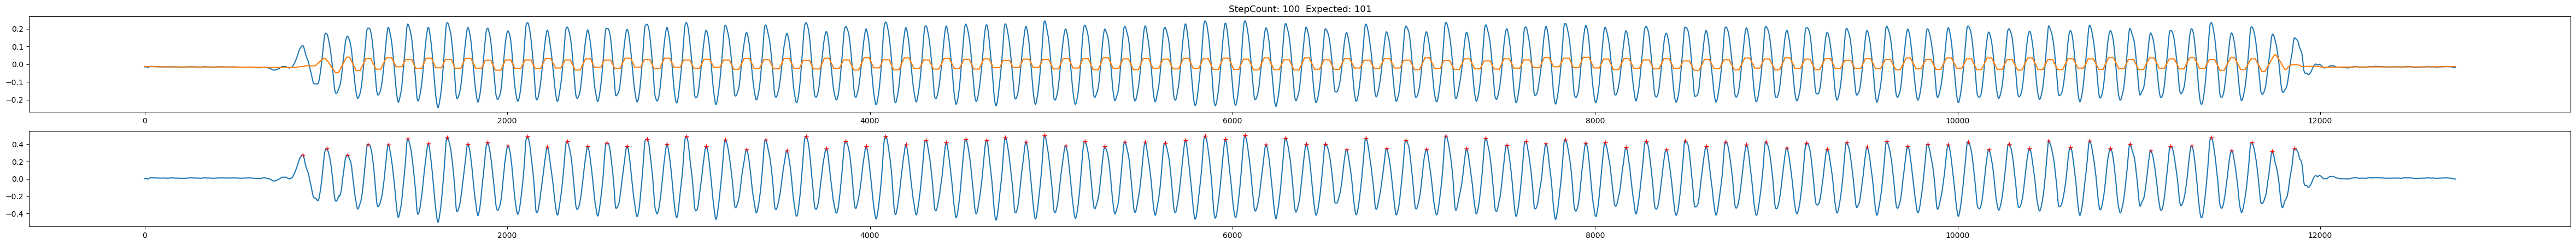

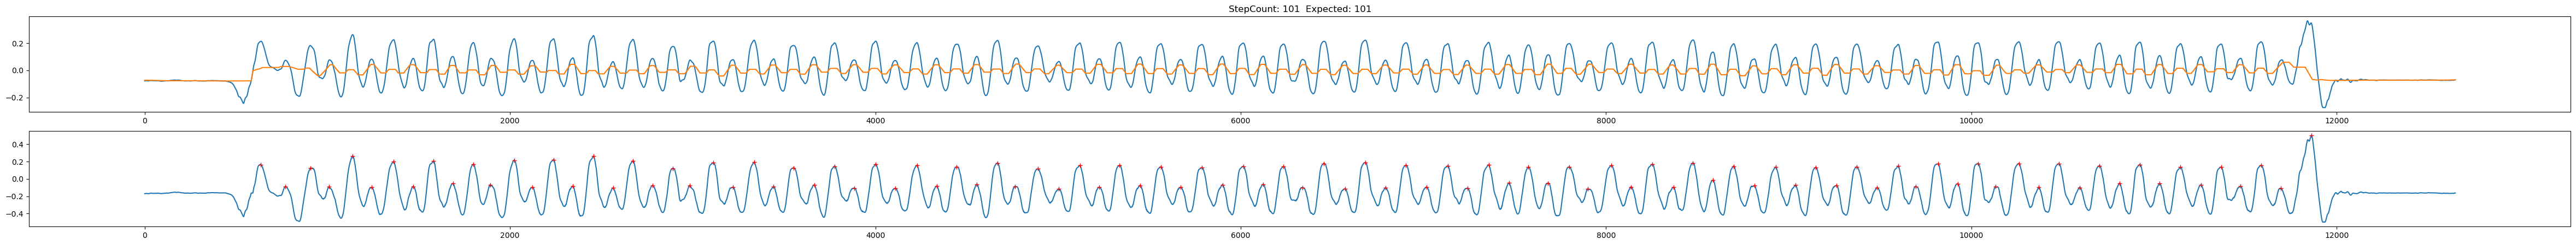

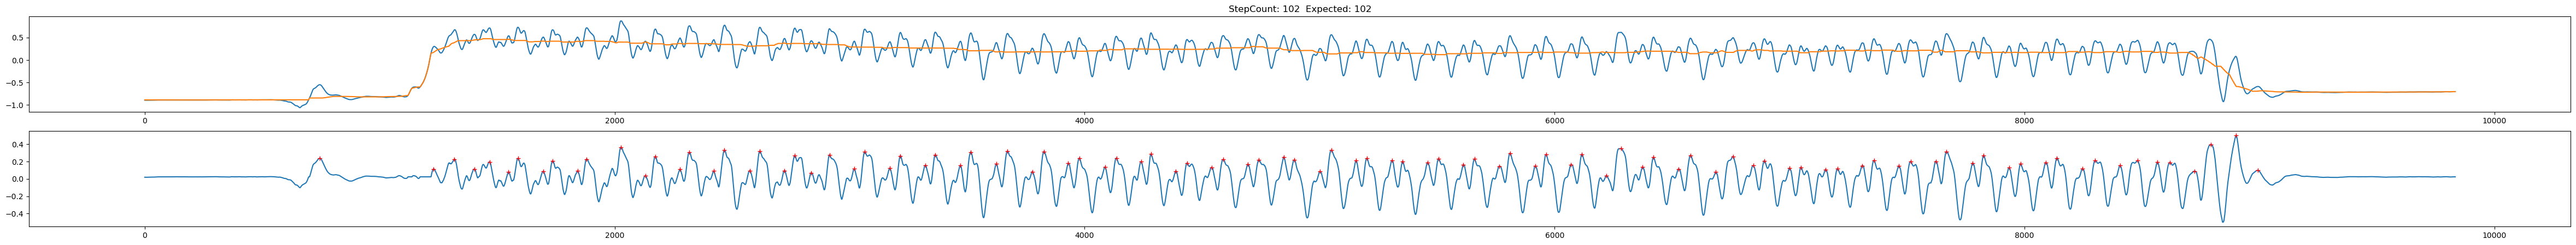

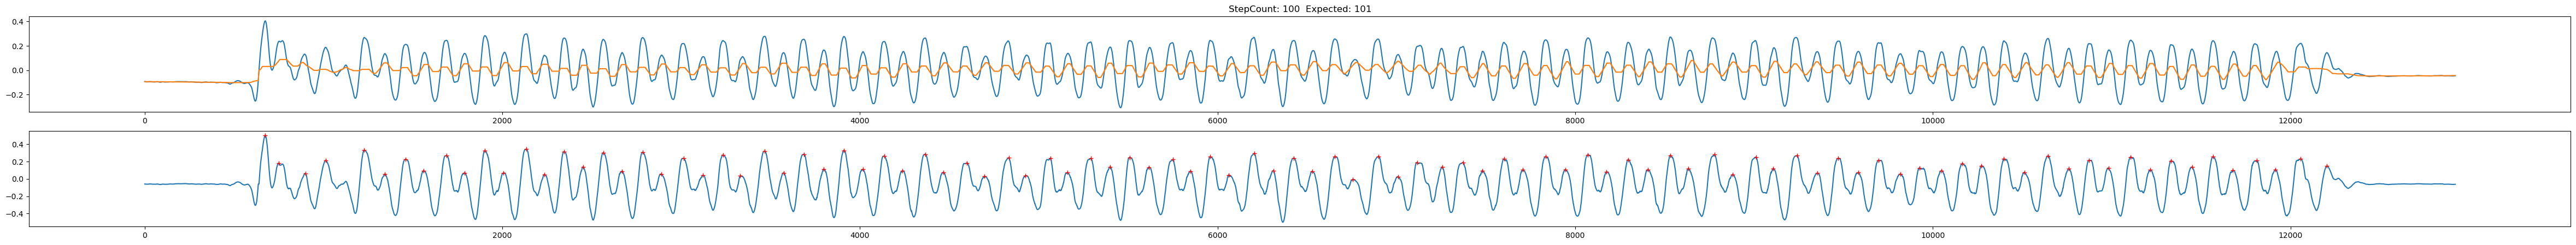

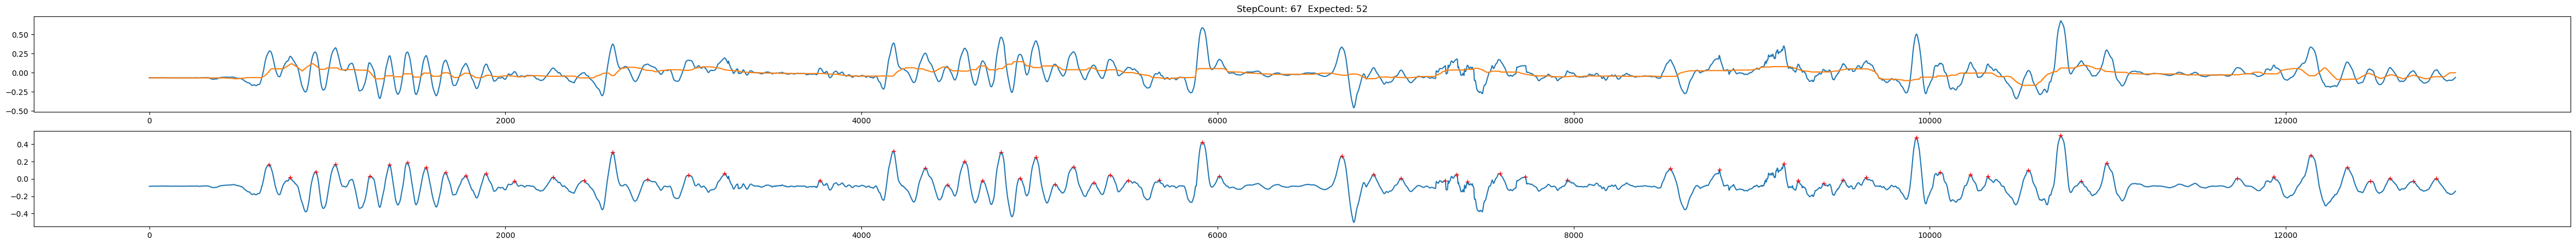

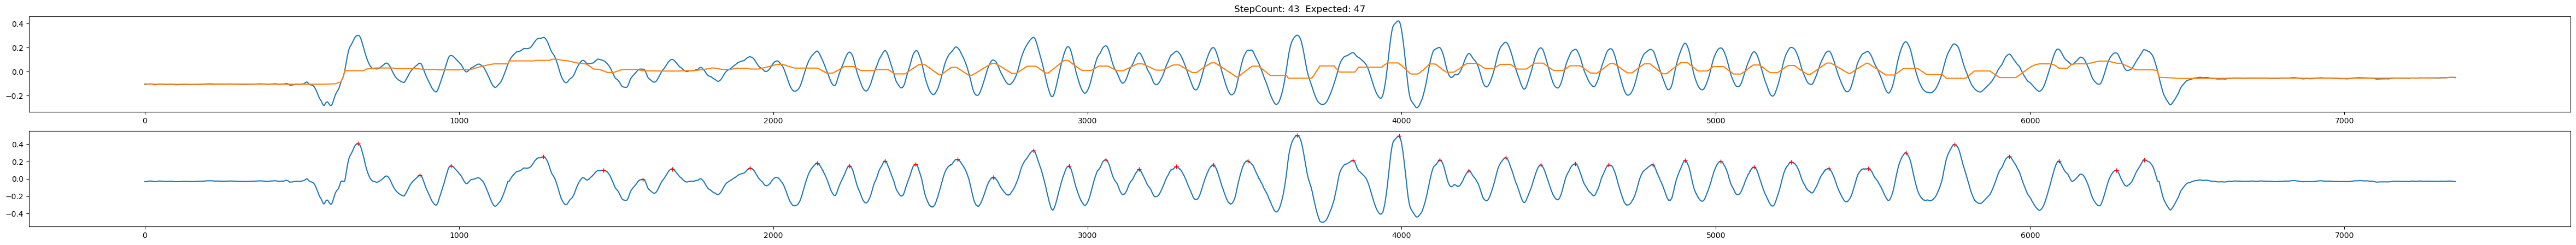

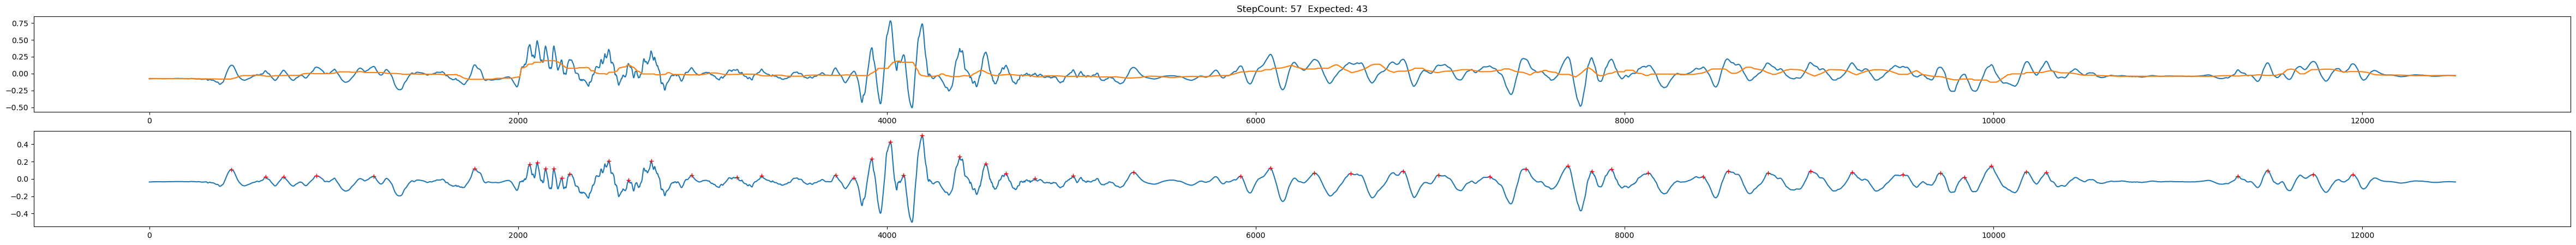

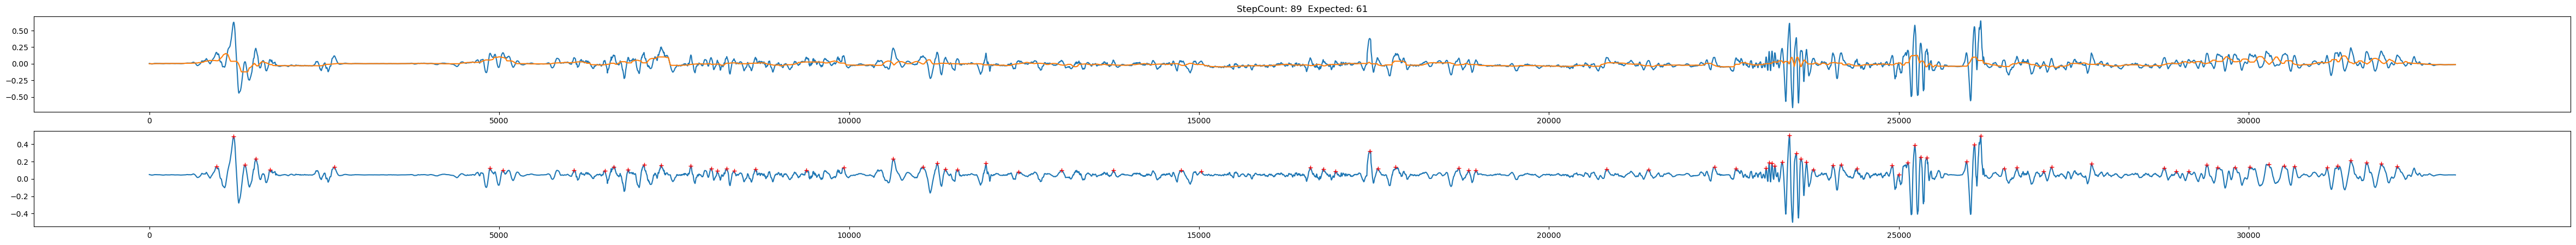

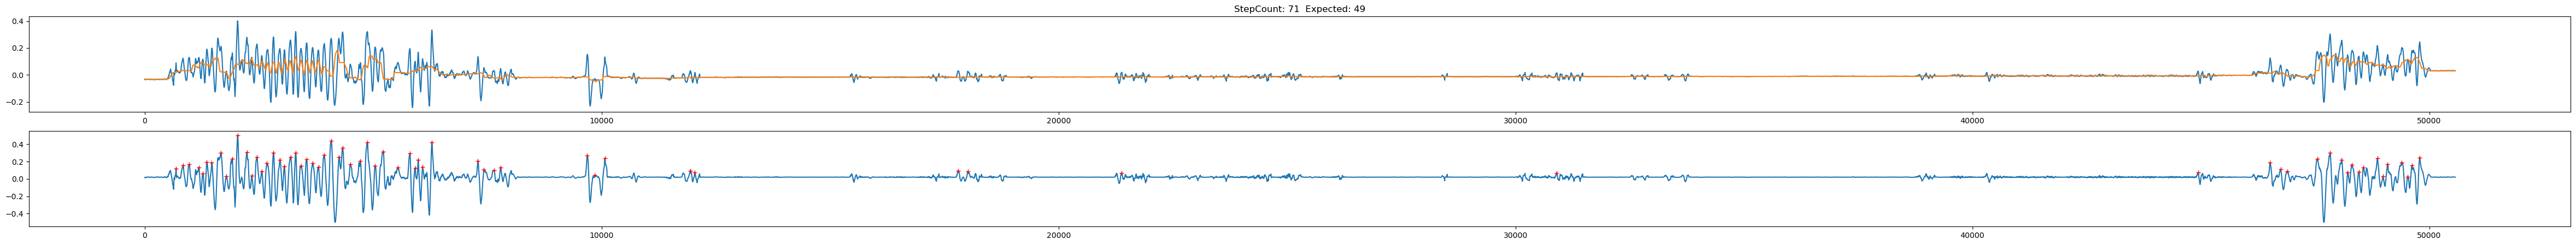

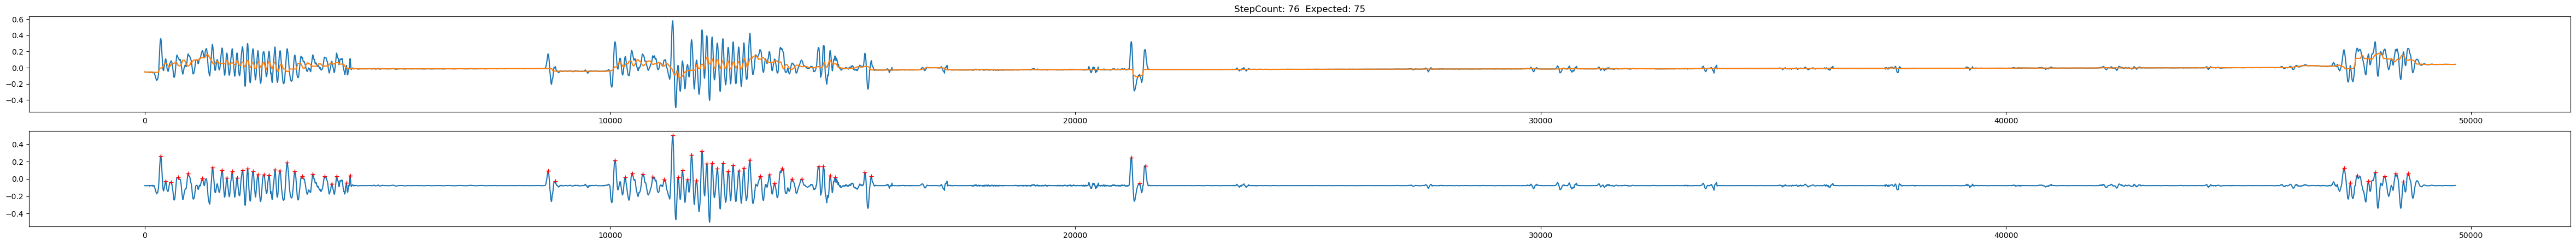

In [40]:
stepCounts = []
ids = []

for i, filename in enumerate(filenames):
    trace = Recording(filename, no_labels=True, mute=True)
    stepCount = 0

    # Your algorithm goes here
    # Make sure, you only use data from the LilyGo Wristband, namely the following 10 keys (as in trace.data[key]):
    # 3-axis accelerometer: key in [ax, ay, az]
    # 3-axis gyro: key in [gx, gy, gz]
    # 3-axis magnetometer: key in [mx, my, mz]
    # IMU temperature: key==temperature
    trace = Recording(filename, no_labels=True, mute=True)
    ax = trace.data['ax']
    ay = trace.data['ay']
    az = trace.data['az']
    
    timestamp_raw = ax.timestamps
    timestamp_ms = timestamp_raw*1000
    sampling_rate = len(timestamp_raw)/timestamp_raw[-1]

    # Calculate raw magnitude of accelerometer signal
    amagn = [sqrt(a**2+ay.values[i]**2+az.values[i]**2)for i, a in enumerate(ax.values)]
    trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', amagn, timestamp_ms)

    # Calculate raw magnitude of accelerometer signal
    gmagn = [sqrt(g**2+gy.values[i]**2+gz.values[i]**2)for i, g in enumerate(gx.values)]
    trace.data['gmagn'] = Dataset.fromLists('Accelerometer magnitude', gmagn, timestamp_ms)

    sos = signal.butter(1, 1.5, 'lowpass', fs=sampling_rate, output='sos')
    gmagn_lowpass_filter = signal.sosfilt(sos, gmagn)

    # Detrend the signal
    mag_detrended = sp.signal.detrend(amagn)
    trace.data['amagn_detrended'] = Dataset.fromLists('Detrended Accelerometer magnitude', mag_detrended, trace.data['ax'].timestamps)



    # Smoothing the signal -----------------------------------------------------------------------------------
    # Denoise with convolution
    filter_window_size = 55
    mag_denoise = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')

    # Find outliers

    # Baseline correction
    baseline, mag_aligned = baseline_err_medfilter(mag_denoise, sampling_rate)

    # Normalization
    mag_norm = normalize(mag_aligned, min_peak_height=0)




    min_peak_height = 0.0
    peak_locations, _ = get_peaks(mag_norm, min_peak_height)
    stepCount = len(peak_locations)
    title = "StepCount: " + str(stepCount) + "  Expected: " + str(labels_csv["Expected"][i])
    print(title)

    # print detected peak

    fig, axes1 = plt.subplots(2,1, figsize=(60, 5)) #figsize is width, height
    axes1[0].set_title(title)
    axes1[0].plot(mag_denoise, alpha=1, label="original")
    axes1[0].plot(baseline, alpha=1, label="baseline")

    axes1[1].plot(mag_norm, alpha=1, label="Filtered mag")
    axes1[1].plot(peak_locations, mag_norm[peak_locations], 'y+', color="red", label="Peak Locations")



    # Append your calculated step counts and the id of the trace to the corresponding array
    stepCounts.append(stepCount)
    ids.append(filename.split('_')[1][:2])

In [ ]:
# Write the detected step counts into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using the text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns ('Id' and 'Predicted') of the .csv file
df = pd.DataFrame({'Id':ids,'Predicted':stepCounts})
df.to_csv('/kaggle/working/submission.csv', index=False)